# [Ateliers: Technologies de l'intelligence Artificielle](https://github.com/wikistat/AI-Frameworks)

<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" width=400, style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# LAB 4 Introduction to Reinforcement Learning  -  Part 1 : Policy Gradient Algorithm

The objectives of this noteboks are the following : 

* Q-Learning on simple Markov Decision Process
* DQN
 
Source : [https://github.com/ageron/handson-ml](https://github.com/ageron/handson-ml) and https://github.com/breeko/Simple-Reinforcement-Learning-with-Tensorflow/blob/master/Part%202%20-%20Policy-based%20Agents%20with%20Keras.ipynb

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with.

## Import librairies

In [1]:
import numpy as np
import random
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures and animations
%matplotlib inline
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML


plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.initializers as ki
import tensorflow.keras.optimizers as ko
import tensorflow.keras.losses as klo
import tensorflow.keras.backend as K


# Gym Librairy
import gym
import pandas as pd


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=400):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

# Q-Learning on Markov Decision Process

## Definition

We will first define a simple markov process on wich we will apply Q-learning algorithm.

here is an illustration of the MDP that we will define.

![images](images/mdp.png)


We store the different action and transition probabilities within a list

In [2]:
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], 
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None],
    ]

Let's use pandas DataFrame visualisation in order to display this table

In [3]:
transition_probabilities_df = pd.DataFrame(transition_probabilities).rename_axis('Actions', axis=1)
transition_probabilities_df.index.name="State"
transition_probabilities_df

Actions,0,1,2
State,,,
0,"[0.7, 0.3, 0.0]","[1.0, 0.0, 0.0]","[0.8, 0.2, 0.0]"
1,"[0.0, 1.0, 0.0]",None,"[0.0, 0.0, 1.0]"
2,None,"[0.8, 0.1, 0.1]",None


We also define the rewards, each actions couple state/action will lead to.

In [4]:
rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
    ]

rewards_df = pd.DataFrame(rewards).rename_axis('Actions', axis=1)
rewards_df.index.name="State"
rewards_df

Actions,0,1,2
State,,,
0,"[10, 0, 0]","[0, 0, 0]","[0, 0, 0]"
1,"[0, 0, 0]","[0, 0, 0]","[0, 0, -50]"
2,"[0, 0, 0]","[40, 0, 0]","[0, 0, 0]"


And the list of possible action that can be taken at each state.

In [5]:
possible_actions = [[0, 1, 2], [0, 2], [1]]

Finally we define now a class that will act as a Gym environment. 

* The environent is the MDP.
* The observation is the current step.
* The action possible are the three actions we previously define.

In [6]:
class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        return self.state, reward

In [7]:
def run_episode(policy, n_steps, start_state=0):
    env = MDPEnvironment()
    for step in range(n_steps):
        action = policy(env.state)
        state, reward = env.step(action)
    return env.total_rewards


## Hard Coded Policy

In [8]:
def policy_random(state):
    return np.random.choice(possible_actions[state])


all_score = []
for episode in range(1000):
    all_score.append(run_episode(policy_random, n_steps=100))
print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_score), np.std(all_score), np.min(all_score), np.max(all_score)))


Summary: mean=-25.6, std=86.104750, min=-320, max=220


**Exercise** Which policy will be the safest? The more risky? Implement it and test it. What can you say about their results?

## Q-Learning

Let's know implement Q-learning algorithm to learn a bette policy!

Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. 
Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action that has the highest Q-Value (i.e., the greedy policy).

In [9]:
n_states = 3
n_actions = 3
n_steps = 20
alpha = 0.01  #<-- Learning Rate
gamma = 0.99  #<-- The discount rate


 
exploration_policy = policy_random #<-- Policy that we will play during exploration
q_values = np.full((n_states, n_actions), -np.inf) #<-- Policy that we will be updated
for state, actions in enumerate(possible_actions):
    q_values[state][actions]=0
q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

Learning Q_values

In [10]:
env = MDPEnvironment()
for step in range(n_steps):    
    action = exploration_policy(env.state) 
    state = env.state
    next_state, reward = env.step(action)
    next_value = np.max(q_values[next_state]) # greedy policy
    q_values[state, action] = (1-alpha)*q_values[state, action] + alpha*(reward + gamma * next_value)
q_values

array([[ 9.90000000e-02,  9.90000000e-04,  1.93089501e-03],
       [ 0.00000000e+00,            -inf, -1.47322029e+00],
       [           -inf,  1.19079301e+00,            -inf]])

**Exercise** How do we defined the optimal policy from the computed Q_values? Implement it.

In [11]:
def optimal_policy(state):
    return 

In [12]:
# %load solutions/exercise2_2.py

Compute its performance.

In [13]:
all_totals = []
for episode in range(1000):
    all_totals.append(run_episode(optimal_policy, n_steps=100))
print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
print()

TypeError: list indices must be integers or slices, not NoneType

**Q** We have Q learning iteration algorithm to learn the best policy. Would it have been possible to use a different algorithm here? Why?


# DEEP Q Learning on *Pacman-Like* Game

We have seen how to learn an optimal policy on a Markov Decision Process. 

Let's now try to learn how to play a Video Game Like Pacman. 

We won't use directly Pacman here (Even if it's available on Gym environment (see below)). The Pacman game requires GPU to be trained and may need some try and parameter optimization to easily converged. 

Hence, we will start with and simpler environment which looks like Pacman : the [gridworld](https://github.com/awjuliani/DeepRL-Agents/blob/master/gridworld.py) environment.




## Grid World environment

We have a 5x5 blocs where blue, green and red squares. In the environment the agent controls a blue square, and the goal is to navigate to the green squares (reward +1) while avoiding the red squares (reward -1).

### Observation

The observation is the image itself which is a 84x84x3 images.

### Actions

Num | Action
--- | ---
0 | Go Up
1 | Go Down
2 | Go Left
3 | Go Right


### Reward
Reward is 1 for every green square taken and -1 when a red square is taken

### End epsiode
There are no condition limit for an episode to finish

We initiate the environment

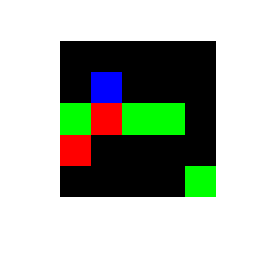

In [18]:
from gridworld import gameEnv
env = gameEnv(partial=False, size=5)

Let's play a game by, fill the actions_list according to the intialised environment

In [19]:
frames = []
cum_reward=0
actions=[]
for step in actions:
    state, reward , end = env.step(step)
    frames.append(state)
    cum_reward+=reward
cum_reward
HTML(plot_animation(frames).to_html5_video())

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

## Data Preprocessing

Original shape: (84, 84, 3)
Processed shape: (84, 84, 1)


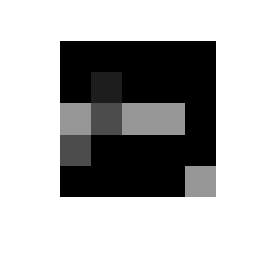

In [23]:
def process_state(state):
    """ This processes the state and converts to black & white. This will help speed up learning
        as the number of parameters will be reduced.
    """
    state = state/255
    return np.expand_dims(np.dot(state[...,:3], [0.2989, 0.5870, 0.1140]),axis=-1)
    return state


plt.imshow(process_state(env.state)[:,:,0],cmap=plt.get_cmap('gray'))
plt.axis("off")

print("Original shape: {}".format(env.state.shape))
print("Processed shape: {}".format(process_state(env.state).shape))

* It could just take a state-action pair (s,a) as input, and out‐ put an estimate of the corresponding Q-Value Q(s,a), but since the actions are dis‐ crete it is more convenient to use a neural network that takes only a state s as input and outputs one Q-Value estimate per action.

# Learning to Play MsPacman Using the DQN Algorithm

**Warning**: Unfortunately, the first version of the book contained two important errors in this section.

1. The actor DQN and critic DQN should have been named _online DQN_ and _target DQN_ respectively. Actor-critic algorithms are a distinct class of algorithms.
2. The online DQN is the one that learns and is copied to the target DQN at regular intervals. The target DQN's only role is to estimate the next state's Q-Values for each possible action. This is needed to compute the target Q-Values for training the online DQN, as shown in this equation:

$y(s,a) = \text{r} + \gamma . \underset{a'}{\max} \, Q_\text{target}(s', a')$

* $y(s,a)$ is the target Q-Value to train the online DQN for the state-action pair $(s, a)$.
* $r$ is the reward actually collected after playing action $a$ in state $s$.
* $\gamma$ is the discount rate.
* $s'$ is the state actually reached after played action $a$ in state $s$.
* $a'$ is one of the possible actions in state $s'$.
* $Q_\text{target}(s', a')$ is the target DQN's estimate of the Q-Value of playing action $a'$ while in state $s'$.

I hope these errors did not affect you, and if they did, I sincerely apologize.

## Creating the MsPacman environment

In [9]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

(210, 160, 3)

In [10]:
env.action_space

Discrete(9)

## Preprocessing

Preprocessing the images is optional but greatly speeds up training.

In [11]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)/128

img = preprocess_observation(obs)
img.shape

(88, 80, 1)

Note: the `preprocess_observation()` function is slightly different from the one in the book: instead of representing pixels as 64-bit floats from -1.0 to 1.0, it represents them as signed bytes (from -128 to 127). The benefit is that the replay memory will take up roughly 8 times less RAM (about 6.5 GB instead of 52 GB). The reduced precision has no visible impact on training.

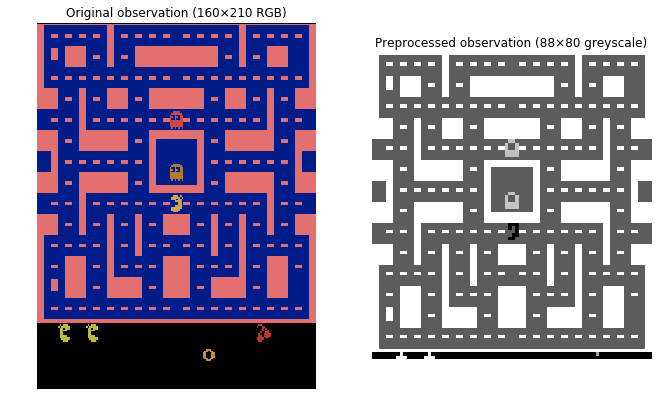

In [12]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

## Build DQN

Note: instead of using `tf.contrib.layers.convolution2d()` or `tf.contrib.layers.conv2d()` (as in the first version of the book), we now use the `tf.layers.conv2d()`, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same, except that the parameter names have changed slightly:
* the `num_outputs` parameter was renamed to `filters`,
* the `stride` parameter was renamed to `strides`,
* the `_fn` suffix was removed from parameter names that had it (e.g., `activation_fn` was renamed to `activation`),
* the `weights_initializer` parameter was renamed to `kernel_initializer`,
* the weights variable was renamed to `"kernel"` (instead of `"weights"`), and the biases variable was renamed from `"biases"` to `"bias"`,
* and the default `activation` is now `None` instead of `tf.nn.relu`.

In [13]:
input_height = 88
input_width = 80
input_channels = 1
initializer =  ki.VarianceScaling()



def q_network():
    q_model = km.Sequential()
    q_model.add(kl.Conv2D(32,kernel_size=(8,8),strides=(4,4),padding="SAME", activation="relu", kernel_initializer = initializer, 
                          input_shape=(input_height, input_width, input_channels), data_format="channels_last"))
    q_model.add(kl.Conv2D(64,kernel_size=(4,4),strides=(2,2),padding="SAME", activation="relu",  kernel_initializer = initializer))
    q_model.add(kl.Conv2D(64,kernel_size=(3,4),strides=(1,1),padding="SAME", activation="relu",  kernel_initializer = initializer))
    q_model.add(kl.Flatten())
    q_model.add(kl.Dense(512, activation="relu", kernel_initializer=initializer))
    q_model.add(kl.Dense(9, activation="linear", kernel_initializer=initializer))
    
    learning_rate = 0.001
    momentum = 0.95
    Opt = ko.SGD(lr=learning_rate, momentum=momentum , decay=0.0, nesterov=True)
    q_model.compile(loss='mean_squared_error',optimizer=Opt) # later change to square loss if error >1 else linear



    return q_model


In [14]:

if False : 
    with tf.variable_scope("train"):
        X_action = tf.placeholder(tf.int32, shape=[None])
        y = tf.placeholder(tf.float32, shape=[None, 1])
        q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                                axis=1, keepdims=True)
        error = tf.abs(y - q_value)
        clipped_error = tf.clip_by_value(error, 0.0, 1.0)
        linear_error = 2 * (error - clipped_error)
        loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

        global_step = tf.Variable(0, trainable=False, name='global_step')
        optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
        training_op = optimizer.minimize(loss, global_step=global_step)

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Note: in the first version of the book, the loss function was simply the squared error between the target Q-Values (`y`) and the estimated Q-Values (`q_value`). However, because the experiences are very noisy, it is better to use a quadratic loss only for small errors (below 1.0) and a linear loss (twice the absolute error) for larger errors, which is what the code above computes. This way large errors don't push the model parameters around as much. Note that we also tweaked some hyperparameters (using a smaller learning rate, and using Nesterov Accelerated Gradients rather than Adam optimization, since adaptive gradient algorithms may sometimes be bad, according to this [paper](https://arxiv.org/abs/1705.08292)). We also tweaked a few other hyperparameters below (a larger replay memory, longer decay for the $\epsilon$-greedy policy, larger discount rate, less frequent copies of the online DQN to the target DQN, etc.).

We use this `ReplayMemory` class instead of a `deque` because it is much faster for random access (thanks to @NileshPS who contributed it). Moreover, we default to sampling with replacement, which is much faster than sampling without replacement for large replay memories.

In [15]:
class ExperienceReplay:
    def __init__(self,buffer_size=500000):
        """ Data structure used to hold game experiences """
        # Buffer will contain [state,action,reward,next_state,done]
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        """ Adds list of experiences to the buffer """
        # Extend the stored experiences
        self.buffer.extend(experience)
        # Keep the last buffer_size number of experiences
        self.buffer = self.buffer[-self.buffer_size:]
        
    def sample(self, size):
        """ Returns a sample of experiences from the buffer """
        sample_idxs = np.random.randint(len(self.buffer),size=size)
        sample_output = [self.buffer[idx] for idx in sample_idxs]
        sample_output = np.reshape(sample_output,(size,-1))
        return sample_output

In [16]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [17]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [18]:
prob_random_start = 1
prob_random_end = 0.1
annealing_steps = 2000000

In [19]:
def update_target_graph(main_graph, target_graph, tau):
    updated_weights = (np.array(main_graph.get_weights()) * tau) + \
        (np.array(target_graph.get_weights()) * (1 - tau))
    target_graph.set_weights(updated_weights)

In [20]:
num_episodes = 4000000  # total number of training steps
pre_train_episodes = 1000  # start training after 10,000 game iterations
update_freq = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
y = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
num_epochs=20

A few variables for tracking progress:

In [21]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0
tau=1

In [22]:
# Reset everything
K.clear_session()

# Setup our Q-networks
online_q_values = q_network()
target_q_values = q_network()


# Make the networks equal
update_target_graph(online_q_values, target_q_values, 1)

# Setup our experience replay
experience_replay = ExperienceReplay()

# We'll begin by acting complete randomly. As we gain experience and improve,
# we will begin reducing the probability of acting randomly, and instead
# take the actions that our Q network suggests
prob_random = prob_random_start
prob_random_drop = (prob_random_start - prob_random_end) / annealing_steps

num_steps = [] # Tracks number of steps per episode
rewards = [] # Tracks rewards per episode
total_steps = 0 # Tracks cumulative steps taken in training

print_every = 100 # How often to print status
save_every = 5 # How often to save

losses = [0] # Tracking training losses

num_episode = 0

while num_episode < num_episodes:
    # Create an experience replay for the current episode
    episode_buffer = ExperienceReplay()
    
     # Get the game state from the environment
        
        
    state = env.reset()
    for skip in range(skip_start): # skip the start of each game
        state, reward, done, info = env.step(0)
    state = preprocess_observation(state)
    
    done = False # Game is complete
    sum_rewards = 0 # Running sum of rewards in episode
    cur_step = 0 # Running sum of number of steps taken in episode
    
    
    while not(done):
        cur_step += 1
        total_steps += 1

        if np.random.rand() < prob_random or \
            num_episode < pre_train_episodes:
                # Act randomly based on prob_random or if we
                # have not accumulated enough pre_train episodes
                action = np.random.randint(9)
        else:
            # Decide what action to take from the Q network
            action = np.argmax(online_q_values.predict(np.array([state])))

        # Take the action and retrieve the next state, reward and done
        next_state, reward, done, info = env.step(action)
        next_state = preprocess_observation(next_state)

        # Setup the episode to be stored in the episode buffer
        episode = np.array([[state],action,reward,[next_state],done])
        episode = episode.reshape(1,-1)

        # Store the experience in the episode buffer
        episode_buffer.add(episode)

        # Update the running rewards
        sum_rewards += reward

        # Update the state
        state = next_state
    if num_episode > pre_train_episodes:
        # Training the network
        if prob_random > prob_random_end:
                # Drop the probability of a random action
                prob_random -= prob_random_drop
                
        if num_episode % update_freq == 0:
            for num_epoch in range(num_epochs):
                # Train batch is [[state,action,reward,next_state,done],...]
                train_batch = experience_replay.sample(batch_size)

                # Separate the batch into its components
                train_state, train_action, train_reward, \
                    train_next_state, train_done = train_batch.T

                # Convert the action array into an array of ints so they can be used for indexing
                train_action = train_action.astype(np.int)

                # Stack the train_state and train_next_state for learning
                train_state = np.vstack(train_state)
                train_next_state = np.vstack(train_next_state)

                # Our predictions (actions to take) from the main Q network
                target_q = target_q_values.predict(train_state)

                # The Q values from our target network from the next state
                target_q_next_state = online_q_values.predict(train_next_state)
                train_next_state_action = np.argmax(target_q_next_state,axis=1)
                train_next_state_action = train_next_state_action.astype(np.int)

                # Tells us whether game over or not
                # We will multiply our rewards by this value
                # to ensure we don't train on the last move
                train_gameover = train_done == 0

                # Q value of the next state based on action
                train_next_state_values = target_q_next_state[range(batch_size), train_next_state_action]

                # Reward from the action chosen in the train batch
                actual_reward = train_reward + (y * train_next_state_values * train_gameover)
                target_q[range(batch_size), train_action] = actual_reward

                # Train the main model
                loss = online_q_values.train_on_batch(train_state, target_q)
                losses.append(loss)

            # Update the target model with values from the main model
            update_target_graph(online_q_values, target_q_values, tau)

            #if (num_episode + 1) % save_every == 0:
            #    # Save the model
            #    online_q_values.model.save_weights(main_weights_file)
            #    target_q_values.model.save_weights(target_weights_file)

    
    # Increment the episode
    num_episode += 1
    
    experience_replay.add(episode_buffer.buffer)
    num_steps.append(cur_step)
    rewards.append(sum_rewards)
    
    if num_episode % print_every == 0:
        # Print progress
        mean_loss = np.mean(losses[-(print_every * num_epochs):])

        print("Num episode: {} Mean reward: {:0.4f} Prob random: {:0.4f}, Loss: {:0.04f}".format(
            num_episode, np.mean(rewards[-print_every:]), prob_random, mean_loss))

Num episode: 100 Mean reward: 213.0000 Prob random: 1.0000, Loss: 0.0000
Num episode: 200 Mean reward: 221.3000 Prob random: 1.0000, Loss: 0.0000
Num episode: 300 Mean reward: 194.7000 Prob random: 1.0000, Loss: 0.0000
Num episode: 400 Mean reward: 203.3000 Prob random: 1.0000, Loss: 0.0000
Num episode: 500 Mean reward: 218.0000 Prob random: 1.0000, Loss: 0.0000
Num episode: 600 Mean reward: 200.1000 Prob random: 1.0000, Loss: 0.0000
Num episode: 700 Mean reward: 218.6000 Prob random: 1.0000, Loss: 0.0000
Num episode: 800 Mean reward: 224.8000 Prob random: 1.0000, Loss: 0.0000
Num episode: 900 Mean reward: 226.2000 Prob random: 1.0000, Loss: 0.0000
Num episode: 1000 Mean reward: 203.1000 Prob random: 1.0000, Loss: 0.0000
Num episode: 1100 Mean reward: 209.4000 Prob random: 1.0000, Loss: 0.5013
Num episode: 1200 Mean reward: 209.2000 Prob random: 0.9999, Loss: 0.6541
Num episode: 1300 Mean reward: 215.1000 Prob random: 0.9999, Loss: 0.6445
Num episode: 1400 Mean reward: 227.5000 Prob ra

KeyboardInterrupt: 

In [ ]:

loss

In [ ]:

    if num_episode > pre_train_episodes:
        # Training the network

        if prob_random > prob_random_end:
            # Drop the probability of a random action
            prob_random -= prob_random_drop

        if num_episode % update_freq == 0:
            for num_epoch in range(num_epochs):
                # Train batch is [[state,action,reward,next_state,done],...]
                train_batch = experience_replay.sample(batch_size)

                # Separate the batch into its components
                train_state, train_action, train_reward, \
                    train_next_state, train_done = train_batch.T
                    
                # Convert the action array into an array of ints so they can be used for indexing
                train_action = train_action.astype(np.int)

                # Stack the train_state and train_next_state for learning
                train_state = np.vstack(train_state)
                train_next_state = np.vstack(train_next_state)

                # Our predictions (actions to take) from the main Q network
                target_q = target_qn.model.predict(train_state)
                
                # The Q values from our target network from the next state
                target_q_next_state = main_qn.model.predict(train_next_state)
                train_next_state_action = np.argmax(target_q_next_state,axis=1)
                train_next_state_action = train_next_state_action.astype(np.int)
                
                # Tells us whether game over or not
                # We will multiply our rewards by this value
                # to ensure we don't train on the last move
                train_gameover = train_done == 0

                # Q value of the next state based on action
                train_next_state_values = target_q_next_state[range(batch_size), train_next_state_action]

                # Reward from the action chosen in the train batch
                actual_reward = train_reward + (y * train_next_state_values * train_gameover)
                target_q[range(batch_size), train_action] = actual_reward
                
                # Train the main model
                loss = main_qn.model.train_on_batch(train_state, target_q)
                losses.append(loss)
                
            # Update the target model with values from the main model
            update_target_graph(main_qn.model, target_qn.model, tau)

            if (num_episode + 1) % save_every == 0:
                # Save the model
                main_qn.model.save_weights(main_weights_file)
                target_qn.model.save_weights(target_weights_file)
    

    # Increment the episode
    num_episode += 1

    experience_replay.add(episode_buffer.buffer)
    num_steps.append(cur_step)
    rewards.append(sum_rewards)
        
    if num_episode % print_every == 0:
        # Print progress
        mean_loss = np.mean(losses[-(print_every * num_epochs):])

        print("Num episode: {} Mean reward: {:0.4f} Prob random: {:0.4f}, Loss: {:0.04f}".format(
            num_episode, np.mean(rewards[-print_every:]), prob_random, mean_loss))
        if np.mean(rewards[-print_every:]) >= goal:
            print("Training complete!")
            break

And now the main training loop!

In [ ]:
while True:
    step = global_step.eval()
    if step >= n_steps:
        break
    iteration += 1
    print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
        iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
    if done: # game over, start again
        obs = env.reset()
        for skip in range(skip_start): # skip the start of each game
            obs, reward, done, info = env.step(0)
        state = preprocess_observation(obs)

    # Online DQN evaluates what to do
    q_values = online_q_values.eval(feed_dict={X_state: [state]})
    action = epsilon_greedy(q_values, step)

    # Online DQN plays
    obs, reward, done, info = env.step(action)
    next_state = preprocess_observation(obs)

    # Let's memorize what happened
    replay_memory.append((state, action, reward, next_state, 1.0 - done))
    state = next_state

    # Compute statistics for tracking progress (not shown in the book)
    total_max_q += q_values.max()
    game_length += 1
    if done:
        mean_max_q = total_max_q / game_length
        total_max_q = 0.0
        game_length = 0

    if iteration < training_start or iteration % training_interval != 0:
        continue # only train after warmup period and at regular intervals

    # Sample memories and use the target DQN to produce the target Q-Value
    X_state_val, X_action_val, rewards, X_next_state_val, continues = (
        sample_memories(batch_size))
    next_q_values = target_q_values.eval(
        feed_dict={X_state: X_next_state_val})
    max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
    y_val = rewards + continues * discount_rate * max_next_q_values

    # Train the online DQN
    _, loss_val = sess.run([training_op, loss], feed_dict={
        X_state: X_state_val, X_action: X_action_val, y: y_val})

    # Regularly copy the online DQN to the target DQN
    if step % copy_steps == 0:
        copy_online_to_target.run()

    # And save regularly
    if step % save_steps == 0:
        saver.save(sess, checkpoint_path)

You can interrupt the cell above at any time to test your agent using the cell below. You can then run the cell above once again, it will load the last parameters saved and resume training.

In [ ]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

In [ ]:
plot_animation(frames)